# 1.0 Imports e Leitura dos Dados

In [23]:
import holidays
import joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, r2_score

## 1.1 Leitura dos Dados

In [24]:
df = pd.read_csv('../data/test_data.csv')

df["date"] = pd.to_datetime(df["date"])

## 1.2 Funções Auxiliares

In [25]:
# Função para gerar um relatório com as principais métricas para regressão dado a predição de cada modelo
def regression_report(y_real, y_pred):

    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)

    metrics = {
        "MAE": mae,
        "R²": r2
    }

    print("Regression Report:")
    print("-" * 20)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    
    return metrics

def lagged_features(df, lags=7):

    lagged_data = []

    for app in df["appId"].unique():
        app_data = df[df["appId"] == app].copy()
        for lag in range(1, lags + 1):
            app_data[f"dauReal_t-{lag}"] = app_data["dauReal"].shift(lag)
        app_data["dauReal_t"] = app_data["dauReal"]
        lagged_data.append(app_data)
    
    return pd.concat(lagged_data)

# 2.0 Pipeline de Teste

In [26]:
df = df.sort_values(by=["appId", "date"])

# Janela temporal de Daily Active Users
df_lagged = lagged_features(df, lags=7)
df_lagged = df_lagged.dropna()

# Checa se a data é um final de semana
df_lagged["is_weekend"] = df_lagged["date"].dt.weekday.isin([5, 6])

# Checa se a data é um feriado brasileiro
brazil_holidays = holidays.Brazil(years=2024)
df_lagged["is_brazilian_holiday"] = df_lagged["date"].isin(brazil_holidays)

# Encoding da coluna category
label_encoder = joblib.load("../models/label_encoder.joblib")
df_lagged['category'] = label_encoder.transform(df_lagged['category'])

/tmp/ipykernel_27856/4108349684.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_lagged["is_brazilian_holiday"] = df_lagged["date"].isin(brazil_holidays)


In [27]:
X = df_lagged[
    [
        'dauReal_t-1', 'dauReal_t-2', 'dauReal_t-3', 
        'dauReal_t-4', 'dauReal_t-5', 'dauReal_t-6', 
        'dauReal_t-7', 'category', 'is_weekend', 
        'is_brazilian_holiday'
    ]
]

y = df_lagged['dauReal_t']

In [28]:
trained_model = joblib.load("../models/best_xgboost_model.joblib")

y_pred = trained_model.predict(X)

regression_report(y, y_pred)

Regression Report:
--------------------
MAE: 41676.29
R²: 0.95


{'MAE': 41676.28569022901, 'R²': 0.9525701983723325}

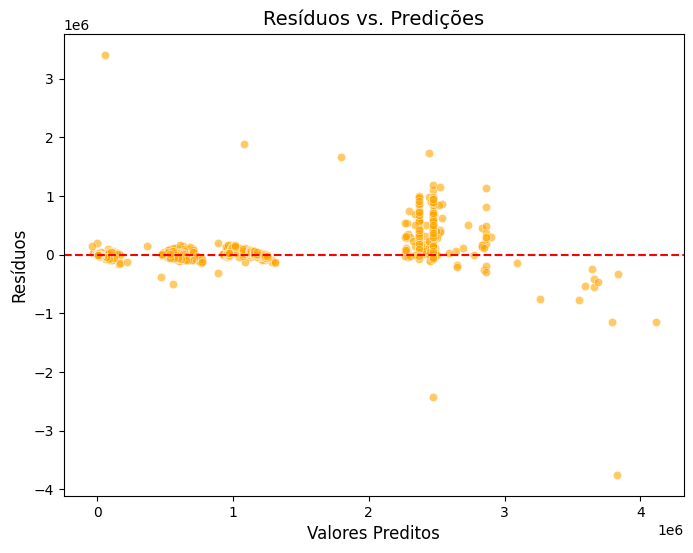

In [29]:
residuos = y - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, color="orange")
plt.axhline(0, color="red", linestyle="--")

plt.title("Resíduos vs. Predições", fontsize=14)
plt.xlabel("Valores Preditos", fontsize=12)
plt.ylabel("Resíduos", fontsize=12)
plt.show()